In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df): 
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_2909969/1732020763.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display


In [2]:
import os
from tqdm import tqdm
tqdm.pandas()

df_dataset = pd.read_csv("data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250108_RCA_LCA.csv", sep='α')
directory = "outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e"

# Load validation epoch results which contain ground truth indices
df_val_epoch = pd.read_csv(os.path.join(directory, "val_epoch5.csv"))

# Create mapping from FileName to ground_truth_idx
filename_to_idx = dict(zip(df_val_epoch['FileName'], df_val_epoch['ground_truth_idx']))

# Assign ground_truth_idx based on FileName
df_dataset['val_text_index'] = df_dataset['FileName'].map(filename_to_idx)

# For each StudyInstanceUID, if any FileName has a ground_truth_idx, 
# propagate that value to all rows with same StudyInstanceUID
def propagate_idx(group):
    valid_idx = group['val_text_index'].dropna().iloc[0] if group['val_text_index'].notna().any() else np.nan
    group['val_text_index'] = valid_idx
    return group

df_dataset = df_dataset.groupby('StudyInstanceUID').progress_apply(propagate_idx)

/tmp/ipykernel_2909969/2542796802.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_dataset = pd.read_csv("data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250108_RCA_LCA.csv", sep='α')
100%|██████████| 34492/34492 [01:23<00:00, 414.40it/s] 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def mode(lst):
    """Return the most common element in lst (tie => any of top)."""
    if not lst:
        return None
    return Counter(lst).most_common(1)[0][0]

def is_valid(x):
    """Return True if x is not NaN and not -1 or '-1'."""
    if pd.isna(x):
        return False
    if x == -1 or x == "-1" or x == -1.0:
        return False
    return True

def build_val_text_index_map(df_dataset, key_col="val_text_index"):
    """
    Build a dict: val_text_index -> list of row(s).
    If each index is unique, each list is length=1.
    """
    index_map = {}
    for _, row in df_dataset.iterrows():
        val_idx = row[key_col]
        if val_idx not in index_map:
            index_map[val_idx] = []
        index_map[val_idx].append(row)
    return index_map


def aggregate_predictions_for_epoch(
    val_text_map,
    predictions_df,
    topk=5,
    vessel_labels=None,
    key_col="val_text_index"
):
    """
    Uses pre-built val_text_map for O(1) lookups, excludes IFR/calcif if == -1 or '-1'.
    """
    if vessel_labels is None:
        vessel_labels = [
            "leftmain_stenosis",
            "lad_stenosis",
            "mid_lad_stenosis", 
            "dist_lad_stenosis",
            "diagonal_stenosis",
            "D2_stenosis",
            "D3_stenosis",
            "lcx_stenosis",
            "dist_lcx_stenosis",
            "lvp_stenosis",
            "marg_d_stenosis",
            "om1_stenosis",
            "om2_stenosis",
            "om3_stenosis",
            "prox_rca_stenosis",
            "mid_rca_stenosis",
            "dist_rca_stenosis",
            "RVG1_stenosis",
            "RVG2_stenosis",
            "pda_stenosis",
            "posterolateral_stenosis",
            "bx_stenosis",
            "lima_or_svg_stenosis",
        ]

    aggregated_rows = []

    for _, row in predictions_df.iterrows():
        gt_idx = row["ground_truth_idx"]
        if gt_idx not in val_text_map:
            continue  # skip if we have no ground-truth row

        # Typically one row in val_text_map[gt_idx], but we handle multiples if needed
        gt_row = val_text_map[gt_idx][0]

        # Collect top-k predicted rows
        predicted_rows = []
        for k_ in range(1, topk + 1):
            pred_col = f"predicted_idx_{k_}"
            if pred_col in row and pd.notna(row[pred_col]):
                pred_idx = int(row[pred_col])
                if pred_idx in val_text_map:
                    predicted_rows.append(val_text_map[pred_idx][0])

        aggregated_dict = {
            "ground_truth_idx": gt_idx,
            "FileName": row["FileName"],
        }

        for vessel in vessel_labels:
            prefix = vessel.replace("_stenosis", "")

            # ============== STENOSIS (continuous) ==============
            pred_sten_vals = [
                pr[vessel] for pr in predicted_rows
                if is_valid(pr[vessel])  # skip -1 or NaN
            ]
            # Predicted stenosis => mean if any valid
            aggregated_dict[f"predicted_{vessel}"] = (
                np.mean(pred_sten_vals) if pred_sten_vals else None
            )
            # Ground truth => store None if invalid
            gt_sten = gt_row[vessel] if vessel in gt_row else None
            aggregated_dict[vessel] = gt_sten if is_valid(gt_sten) else None

            # ============== IFR (continuous) ==============
            ifr_col = prefix + "_IFRHYPEREMIE"

            if ifr_col in gt_row:
                pred_ifr_vals = [
                    pr[ifr_col] for pr in predicted_rows
                    if is_valid(pr[ifr_col])  # skip -1 or NaN
                ]

                aggregated_dict[f"predicted_{ifr_col}"] = (
                    np.mean(pred_ifr_vals) if pred_ifr_vals else None
                )
                gt_ifr = gt_row[ifr_col]
                aggregated_dict[ifr_col] = gt_ifr if is_valid(gt_ifr) else None
            else:
                aggregated_dict[f"predicted_{ifr_col}"] = None
                aggregated_dict[ifr_col] = None

            # ============== CALCIF (categorical) ==============
            calcif_col = prefix + "_calcif"
            if calcif_col in gt_row:
                # Only collect predicted calcif if not -1 / '-1'
                pred_calcif_vals = [
                    pr[calcif_col] for pr in predicted_rows
                    if is_valid(pr[calcif_col])
                ]
                aggregated_dict[f"predicted_{calcif_col}"] = (
                    mode(pred_calcif_vals) if pred_calcif_vals else None
                )
                gt_calcif = gt_row[calcif_col]
                # If GT is -1 or '-1', store None
                aggregated_dict[calcif_col] = gt_calcif if is_valid(gt_calcif) else None
            else:
                aggregated_dict[f"predicted_{calcif_col}"] = None
                aggregated_dict[calcif_col] = None

        # ============== CORONARY DOMINANCE (categorical) ==============
        if "coronary_dominance" in gt_row:
            pred_cd_vals = [
                pr["coronary_dominance"] for pr in predicted_rows
                if is_valid(pr["coronary_dominance"])
            ]
            aggregated_dict["predicted_coronary_dominance"] = (
                mode(pred_cd_vals) if pred_cd_vals else None
            )
            gt_cd = gt_row["coronary_dominance"]
            aggregated_dict["coronary_dominance"] = (
                gt_cd if is_valid(gt_cd) else None
            )
        else:
            aggregated_dict["predicted_coronary_dominance"] = None
            aggregated_dict["coronary_dominance"] = None

        aggregated_rows.append(aggregated_dict)

    return pd.DataFrame(aggregated_rows)


def compute_metrics(agg_df, vessel_labels):

    """
    Computes metrics for each vessel segment:
      - For continuous metrics (stenosis and IFR): MAE and Pearson correlation.
      - For categorical metrics (calcification): accuracy.
      
    Also computes overall accuracy for coronary_dominance.
    
    Args:
        agg_df (pd.DataFrame): DataFrame produced by aggregate_predictions_for_epoch.
        vessel_labels (list): List of vessel stenosis column names.
    
    Returns:
        dict: Dictionary containing metric dictionaries.
            e.g. {
                  'stenosis': { 'mae': { ... }, 'corr': { ... } },
                  'ifr': { 'mae': { ... }, 'corr': { ... } },
                  'calcif': { 'accuracy': { ... } },
                  'coronary_dominance': { 'accuracy': value }
                 }
    """
    metrics = {
        "stenosis": {"mae": {}, "corr": {}},
        "ifr": {"mae": {}, "corr": {}},
        "calcif": {"accuracy": {}}
    }
    
    for vessel in vessel_labels:
        # Stenosis
        gt_stenosis = agg_df[vessel]
        pred_stenosis = agg_df[f"predicted_{vessel}"]
        valid_stenosis = agg_df[[vessel, f"predicted_{vessel}"]].dropna()
        if not valid_stenosis.empty:
            mae_stenosis = np.mean(np.abs(valid_stenosis[vessel] - valid_stenosis[f"predicted_{vessel}"]))
            if len(valid_stenosis) > 1:
                corr_stenosis = valid_stenosis[vessel].corr(valid_stenosis[f"predicted_{vessel}"])
            else:
                corr_stenosis = np.nan
            metrics["stenosis"]["mae"][vessel] = mae_stenosis
            metrics["stenosis"]["corr"][vessel] = corr_stenosis
        else:
            metrics["stenosis"]["mae"][vessel] = None
            metrics["stenosis"]["corr"][vessel] = None

        # IFR
        prefix = vessel.replace("_stenosis", "")
        ifr_col = prefix + "_IFRHYPEREMIE"

        if ifr_col in agg_df.columns:
            valid_ifr = agg_df[[ifr_col, f"predicted_{ifr_col}"]].dropna() if f"predicted_{ifr_col}" in agg_df.columns else pd.DataFrame()
            if not valid_ifr.empty:
                mae_ifr = np.mean(np.abs(valid_ifr[ifr_col] - valid_ifr[f"predicted_{ifr_col}"]))
                if len(valid_ifr) > 1:
                    corr_ifr = valid_ifr[ifr_col].corr(valid_ifr[f"predicted_{ifr_col}"])
                else:
                    corr_ifr = np.nan
                metrics["ifr"]["mae"][vessel] = mae_ifr
                metrics["ifr"]["corr"][vessel] = corr_ifr
            else:
                metrics["ifr"]["mae"][vessel] = None
                metrics["ifr"]["corr"][vessel] = None
        else:
            metrics["ifr"]["mae"][vessel] = None
            metrics["ifr"]["corr"][vessel] = None
        
        # Calcif
        calcif_col = prefix + "_calcif"
        if calcif_col in agg_df.columns:
            valid_calcif = agg_df[[calcif_col, f"predicted_{calcif_col}"]].dropna() if f"predicted_{calcif_col}" in agg_df.columns else pd.DataFrame()
            if not valid_calcif.empty:
                accuracy = np.mean(valid_calcif[calcif_col] == valid_calcif[f"predicted_{calcif_col}"])
                metrics["calcif"]["accuracy"][vessel] = accuracy
            else:
                metrics["calcif"]["accuracy"][vessel] = None
        else:
            metrics["calcif"]["accuracy"][vessel] = None
    
    # Coronary dominance
    if "coronary_dominance" in agg_df.columns and "predicted_coronary_dominance" in agg_df.columns:
        valid_cd = agg_df[["coronary_dominance", "predicted_coronary_dominance"]].dropna()
        if not valid_cd.empty:
            cd_accuracy = np.mean(valid_cd["coronary_dominance"] == valid_cd["predicted_coronary_dominance"])
        else:
            cd_accuracy = None
        metrics["coronary_dominance"] = {"accuracy": cd_accuracy}
    else:
        metrics["coronary_dominance"] = {"accuracy": None}
        
    return metrics

def evaluate_all_epochs(
    df_dataset,
    epoch_csv_paths,
    topk=5,
    vessel_labels=None,
    key_col="val_text_index"
):
    """
    Build the dictionary for fast lookups one time, then evaluate each epoch.
    """
    # Build the lookup map once
    val_text_map = build_val_text_index_map(df_dataset, key_col=key_col)

    results = {}
    for csv_path in epoch_csv_paths:
        print(f"--- Evaluating {csv_path} ---")
        predictions_df = pd.read_csv(csv_path)

        # Aggregate predictions using fast lookups
        agg_df = aggregate_predictions_for_epoch(
            val_text_map=val_text_map,
            predictions_df=predictions_df,
            topk=topk,
            vessel_labels=vessel_labels,
            key_col=key_col
        )

        # Compute metrics
        metrics = compute_metrics(agg_df, vessel_labels=vessel_labels)

        results[os.path.basename(csv_path)] = {
            "agg_df": agg_df,
            "metrics": metrics
        }

    return results


def plot_epoch_metrics_line_charts(results):
    """
    Create line plots of average MAE, average correlation, and average accuracy 
    across multiple epochs, given the 'results' dictionary produced by evaluate_all_epochs.

    Args:
        results (dict): {
            "val_epoch0.csv": {
                "agg_df": <DataFrame>,
                "metrics": {
                   "stenosis": { "mae": {...}, "corr": {...} },
                   "ifr":      { "mae": {...}, "corr": {...} },
                   "calcif":   { "accuracy": {...} },
                   "coronary_dominance": { "accuracy": <float> }
                }
            },
            "val_epoch1.csv": { ... },
            ...
        }
    """

    # Sort epoch keys so we plot in ascending order:
    # If your epoch filenames follow "val_epochX.csv", this sorting will put them in
    # alphanumeric order. If you want numeric sorting by X, you might parse out the integer.

    # Lists to store data for each subplot
    # We'll store them by epoch index
    stenosis_mae_list = []
    ifr_mae_list = []
    stenosis_corr_list = []
    ifr_corr_list = []
    calcif_acc_list = []
    dominance_acc_list = []

    # We also keep track of "epoch labels" for the x-axis
    x_labels = []

    for ep in results.keys():
        # Typically ep might look like "val_epoch0.csv", "val_epoch1.csv", ...
        x_labels.append(ep)  
        
        metrics = results[ep]["metrics"]
        
        # ----- 1) Compute average MAE for stenosis across vessels -----
        sten_mae_vals = [
            v for v in metrics["stenosis"]["mae"].values()
            if v is not None
        ]
        avg_sten_mae = np.mean(sten_mae_vals) if len(sten_mae_vals) > 0 else np.nan
        stenosis_mae_list.append(avg_sten_mae)

        # ----- 2) Compute average MAE for IFR across vessels -----
        ifr_mae_vals = [
            v for v in metrics["ifr"]["mae"].values()
            if v is not None
        ]
        avg_ifr_mae = np.mean(ifr_mae_vals) if len(ifr_mae_vals) > 0 else np.nan
        ifr_mae_list.append(avg_ifr_mae)

        # ----- 3) Compute average correlation for stenosis across vessels -----
        sten_corr_vals = [
            c for c in metrics["stenosis"]["corr"].values()
            if c is not None and not np.isnan(c)
        ]
        avg_sten_corr = np.mean(sten_corr_vals) if len(sten_corr_vals) > 0 else np.nan
        stenosis_corr_list.append(avg_sten_corr)

        # ----- 4) Compute average correlation for IFR across vessels -----
        ifr_corr_vals = [
            c for c in metrics["ifr"]["corr"].values()
            if c is not None
        ]
        avg_ifr_corr = np.mean(ifr_corr_vals) if len(ifr_corr_vals) > 0 else np.nan
        ifr_corr_list.append(avg_ifr_corr)

        # ----- 5) Compute average accuracy for calcification across vessels -----
        calcif_vals = [
            a for a in metrics["calcif"]["accuracy"].values()
            if a is not None
        ]
        avg_calcif_acc = np.mean(calcif_vals) if len(calcif_vals) > 0 else np.nan
        calcif_acc_list.append(avg_calcif_acc)

        # ----- 6) Coronary dominance accuracy (just one value) -----
        dom_acc = metrics["coronary_dominance"]["accuracy"]
        dominance_acc_list.append(dom_acc if dom_acc is not None else np.nan)
    # Now we create a single figure with 3 subplots:
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

    # ============== Subplot 1: MAE (Stenosis) =================
    ax1 = axes[0]
    ax1.plot(x_labels, stenosis_mae_list, marker='o', label="Stenosis MAE", color="blue")
    ax1.set_title("Stenosis MAE across Epochs")
    ax1.set_ylabel("Mean Absolute Error")
    ax1.legend()
    ax1.grid(True)

    # ============== Subplot 2: Correlation (Stenosis) =========
    ax2 = axes[1]
    ax2.plot(x_labels, stenosis_corr_list, marker='o', label="Stenosis Corr", color="green")
    ax2.set_title("Stenosis Correlation across Epochs")
    ax2.set_ylabel("Avg Pearson Correlation")
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True)

    # ============== Subplot 3: Accuracy (calcification & dominance) =
    ax3 = axes[2]
    ax3.plot(x_labels, calcif_acc_list, marker='o', label="Calcif Accuracy", color="orange")
    ax3.plot(x_labels, dominance_acc_list, marker='o', label="Dominance Accuracy", color="brown")
    ax3.set_title("Accuracy across Epochs")
    ax3.set_ylabel("Accuracy")
    ax3.set_ylim(0, 1)
    ax3.set_xlabel("Epoch CSV")
    ax3.legend()
    ax3.grid(True)

    # Make x-labels more readable
    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

    # ============== Separate Plot: IFR MAE ==================
    fig_ifr, ax_ifr = plt.subplots(figsize=(10, 4))
    ax_ifr.plot(x_labels, ifr_mae_list, marker='o', label="IFR MAE", color="red")
    ax_ifr.set_title("IFR MAE across Epochs")
    ax_ifr.set_ylabel("Mean Absolute Error")
    ax_ifr.set_xlabel("Epoch CSV")
    ax_ifr.legend()
    ax_ifr.grid(True)
    plt.setp(ax_ifr.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ============== Separate Plot: IFR Correlation =========
    fig_ifr_corr, ax_ifr_corr = plt.subplots(figsize=(10, 4))
    ax_ifr_corr.plot(x_labels, ifr_corr_list, marker='o', label="IFR Corr", color="purple")
    ax_ifr_corr.set_title("IFR Correlation across Epochs")
    ax_ifr_corr.set_ylabel("Avg Pearson Correlation")
    ax_ifr_corr.set_ylim(0, 1)
    ax_ifr_corr.set_xlabel("Epoch CSV")
    ax_ifr_corr.legend()
    ax_ifr_corr.grid(True)
    plt.setp(ax_ifr_corr.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [4]:
### Plot metrics across epochs ###
import os
import glob
import re


def extract_epoch_num(file_path):
    filename = os.path.basename(file_path)
    match = re.search(r'epoch(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Filename {filename} does not contain an epoch number.")

epoch_csvs = sorted(glob.glob(os.path.join(directory, "val_epoch*.csv")), key=extract_epoch_num)

results = evaluate_all_epochs(
    df_dataset=df_dataset,
    epoch_csv_paths=epoch_csvs,
    topk=5,
    vessel_labels=[
        "leftmain_stenosis",
        "lad_stenosis",
        "mid_lad_stenosis",
        "dist_lad_stenosis",
        "diagonal_stenosis",
        "D2_stenosis",
        "D3_stenosis",
        "lcx_stenosis",
        "dist_lcx_stenosis",
        "lvp_stenosis",
        "marg_d_stenosis",
        "om1_stenosis",
        "om2_stenosis",
        "om3_stenosis",
        "prox_rca_stenosis",
        "mid_rca_stenosis",
        "dist_rca_stenosis",
        "RVG1_stenosis",
        "RVG2_stenosis",
        "pda_stenosis",
        "posterolateral_stenosis",
        "bx_stenosis",
        "lima_or_svg_stenosis",
    ]
)

--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch0.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch1.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch2.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch3.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch4.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch5.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch6.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch7.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch8.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch9.csv ---


In [5]:
display(results)

{'val_epoch0.csv': {'agg_df':        ground_truth_idx                                                                                                                                                   FileName  predicted_leftmain_stenosis  leftmain_stenosis  predicted_leftmain_IFRHYPEREMIE  leftmain_IFRHYPEREMIE  predicted_leftmain_calcif         leftmain_calcif  predicted_lad_stenosis  lad_stenosis  predicted_lad_IFRHYPEREMIE  lad_IFRHYPEREMIE     predicted_lad_calcif              lad_calcif  predicted_mid_lad_stenosis  mid_lad_stenosis  predicted_mid_lad_IFRHYPEREMIE  mid_lad_IFRHYPEREMIE predicted_mid_lad_calcif mid_lad_calcif  predicted_dist_lad_stenosis  dist_lad_stenosis  predicted_dist_lad_IFRHYPEREMIE  dist_lad_IFRHYPEREMIE predicted_dist_lad_calcif dist_lad_calcif  predicted_diagonal_stenosis  diagonal_stenosis  predicted_diagonal_IFRHYPEREMIE  diagonal_IFRHYPEREMIE predicted_diagonal_calcif         diagonal_calcif  predicted_D2_stenosis  D2_stenosis  predicted_D2_IFRHYPEREMIE 

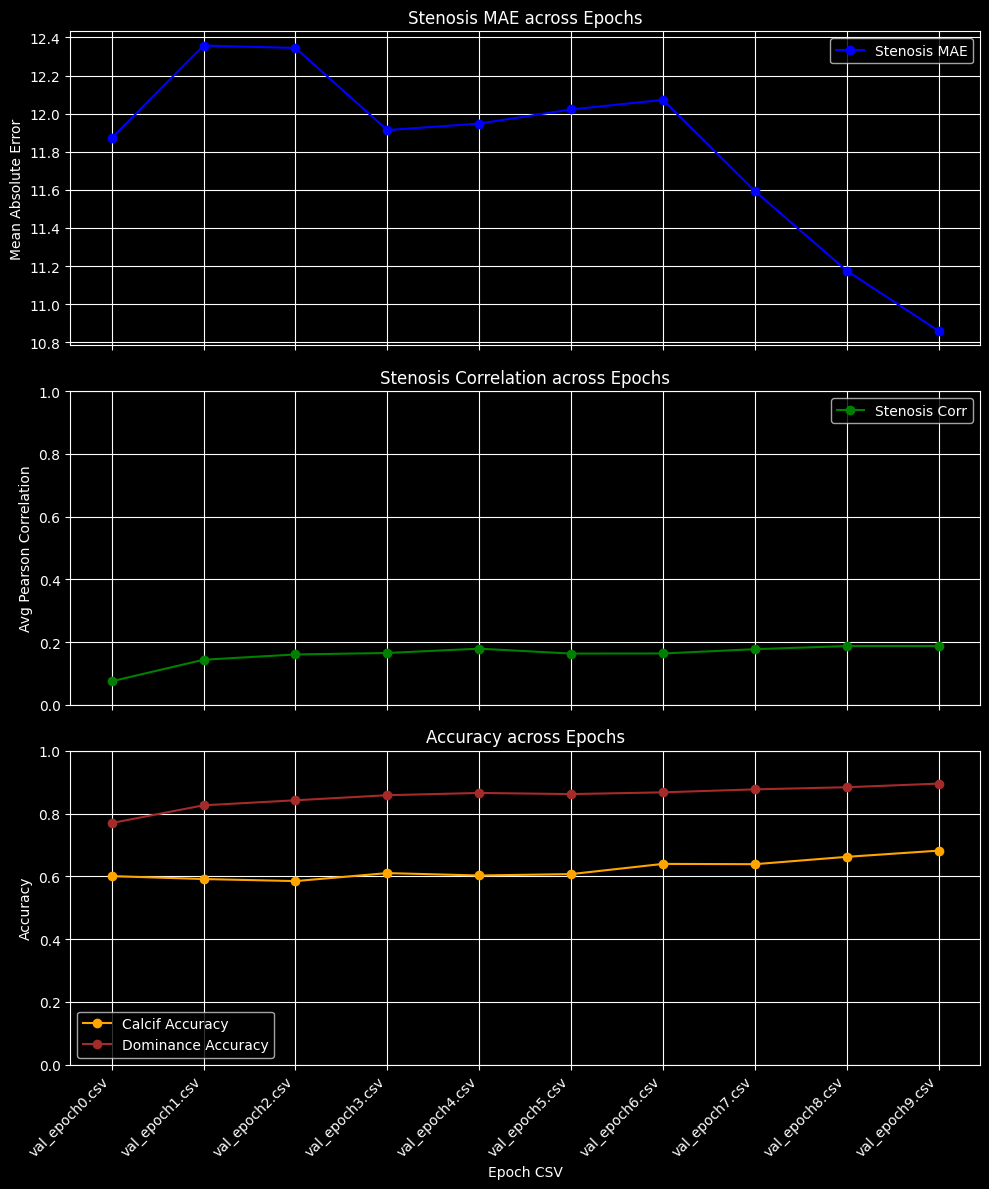

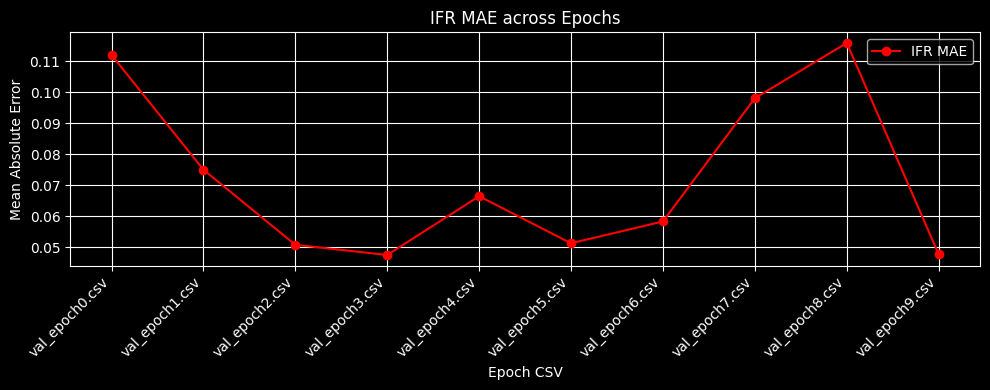

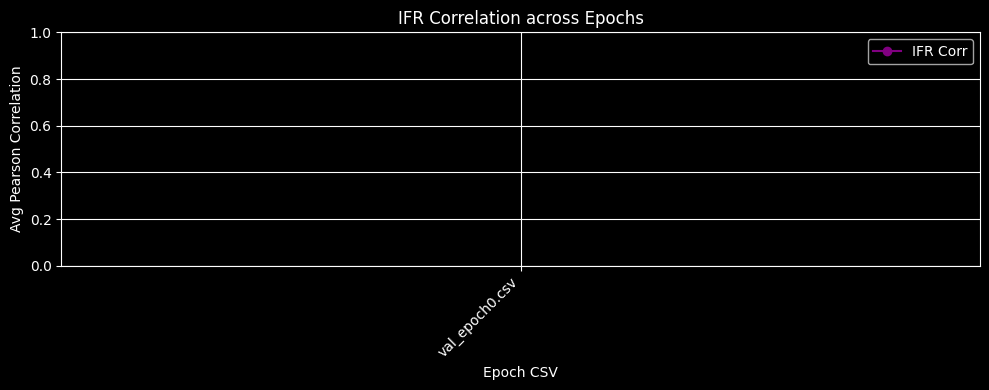

In [6]:
plot_epoch_metrics_line_charts(results)

--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch0.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch1.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch2.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch3.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch4.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch5.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch6.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch7.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch8.csv ---
--- Evaluating outputs/DeepCORO_Clip_Sweep_Single_Video/x3d_m_pretrained_x3d_m_b96_f32_AdamW_lr0.0001078401014773209_20250425-123225_srplnj0e/val_epoch9.csv ---


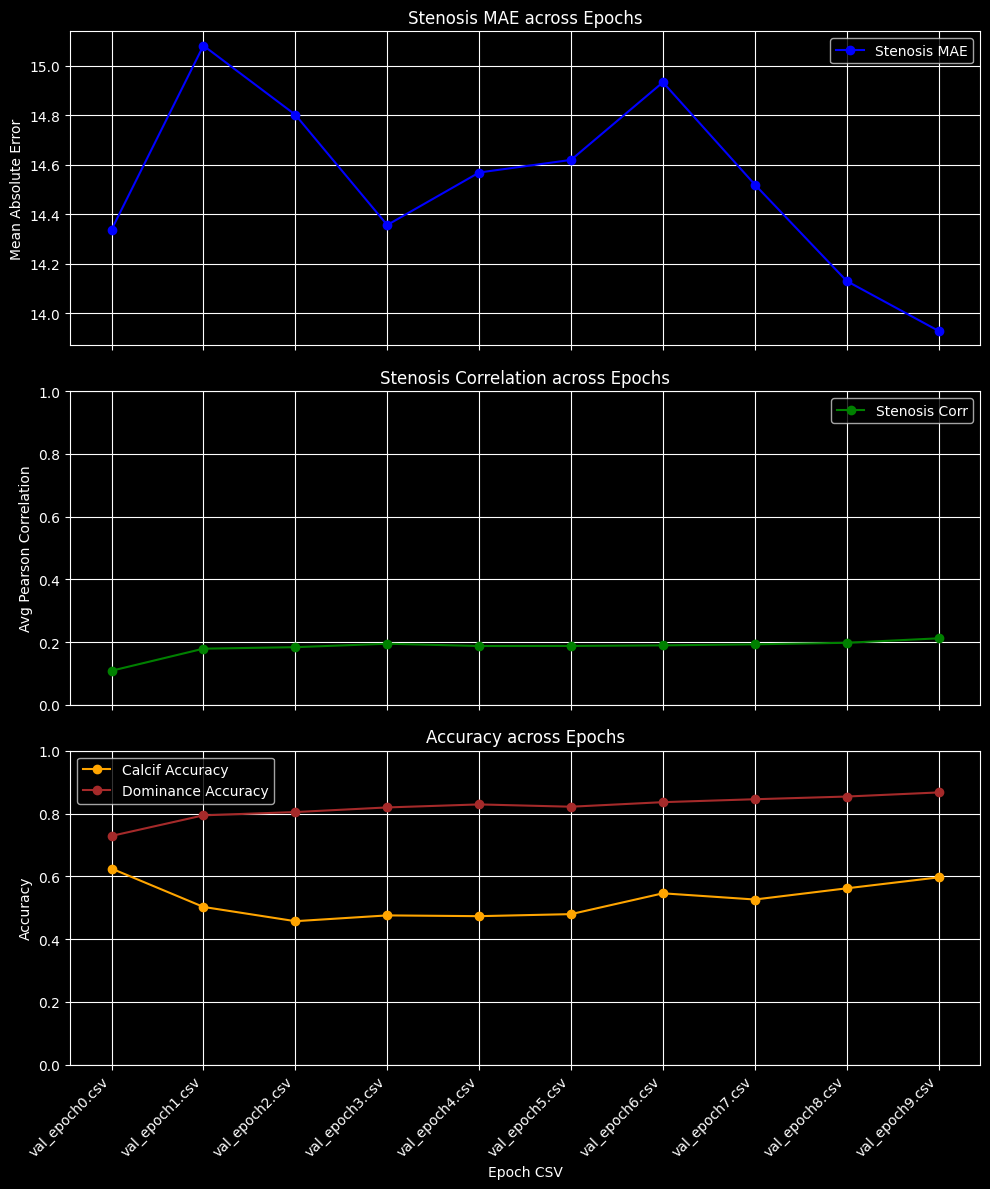

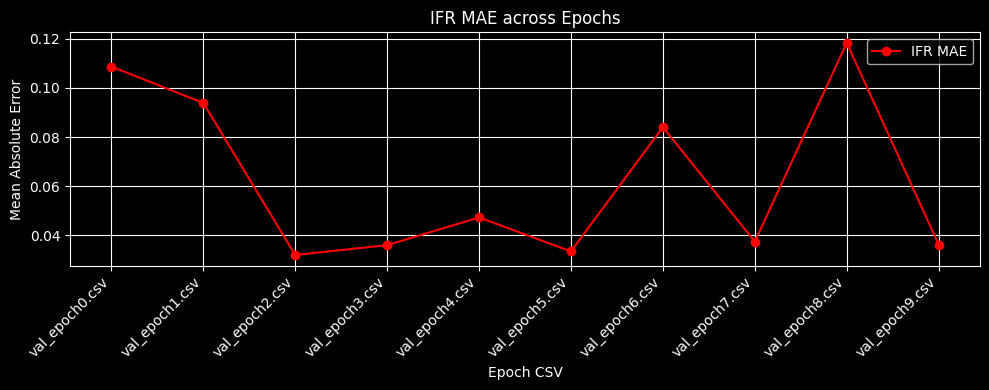

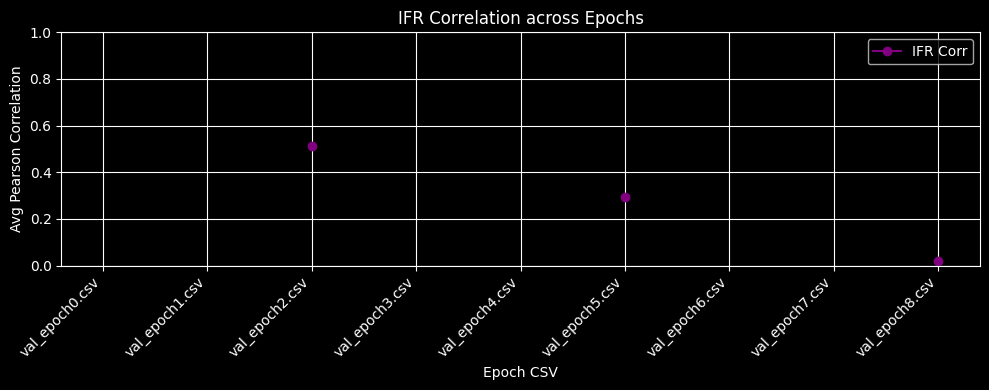

In [7]:
# Define RCA specific vessels
rca_vessels = [
    "prox_rca_stenosis",
    "mid_rca_stenosis", 
    "dist_rca_stenosis",
    "pda_stenosis",
    "posterolateral_stenosis"
]


### Plot metrics across epochs ###
import os
import glob
import re


def extract_epoch_num(file_path):
    filename = os.path.basename(file_path)
    match = re.search(r'epoch(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Filename {filename} does not contain an epoch number.")

epoch_csvs = sorted(glob.glob(os.path.join(directory, "val_epoch*.csv")), key=extract_epoch_num)

results = evaluate_all_epochs(
    df_dataset=df_dataset.loc[df_dataset["object_value"] == 9].reset_index(drop=True),
    epoch_csv_paths=epoch_csvs,
    topk=5,
    vessel_labels=rca_vessels
)
plot_epoch_metrics_line_charts(results)

--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch0.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch1.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch2.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch3.csv ---
--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch4.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch5.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch6.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch7.csv ---
--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch8.csv ---
--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch9.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch10.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch11.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch12.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch13.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--- Evaluating outputs/dev_deep_coro_clip_single_video/mvit_pretrained_mvit_b84_f16_RAdam_lr4.6669536513058017e-05_20250302-204622_pkdtorp4/val_epoch14.csv ---


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


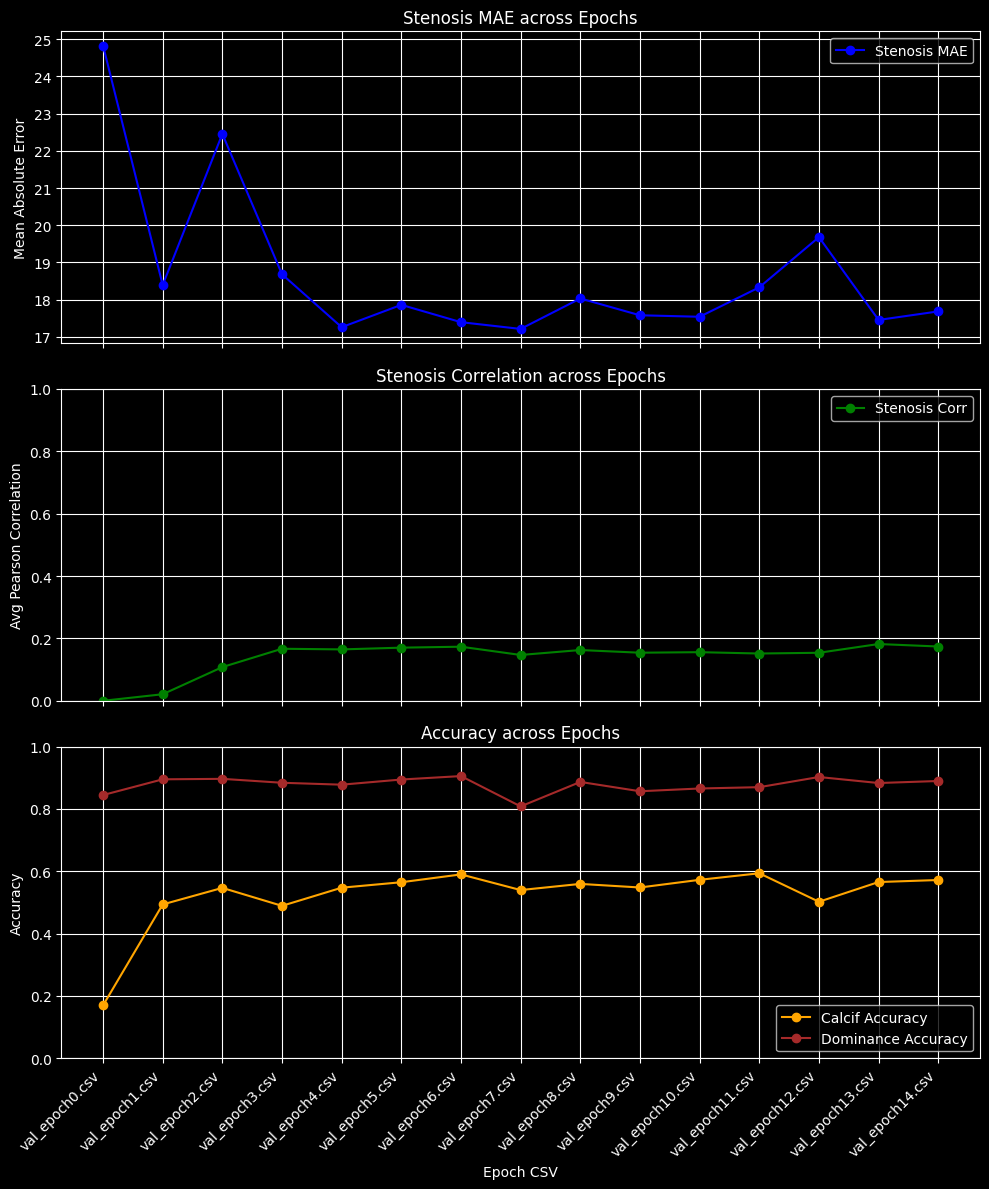

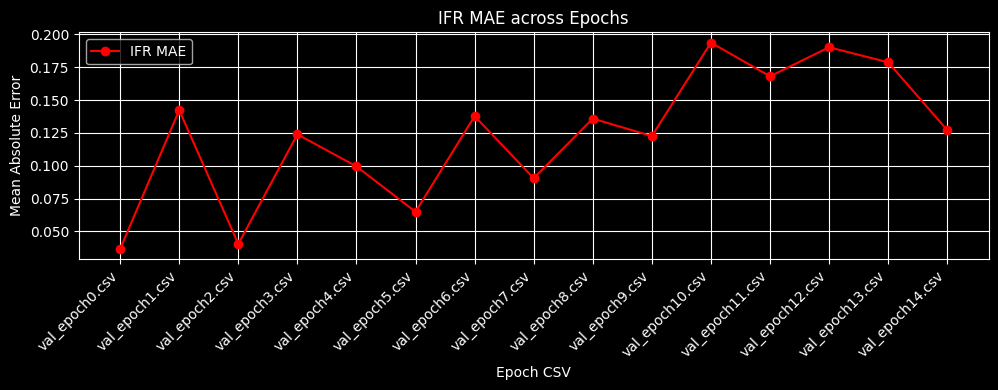

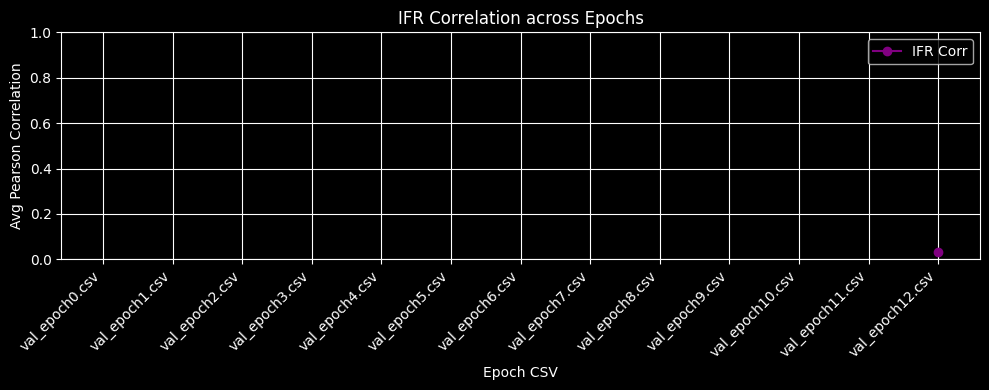

In [6]:

# Define non-RCA vessels 
non_rca_vessels = [
    "leftmain_stenosis",
    "lad_stenosis",
    "mid_lad_stenosis", 
    "dist_lad_stenosis",
    "diagonal_stenosis",
    "D2_stenosis",
    "lcx_stenosis",
    "dist_lcx_stenosis",
    "om1_stenosis",
    "om2_stenosis",
    "bx_stenosis",
    "lima_or_svg_stenosis"
]



### Plot metrics across epochs ###
import os
import glob
import re


def extract_epoch_num(file_path):
    filename = os.path.basename(file_path)
    match = re.search(r'epoch(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Filename {filename} does not contain an epoch number.")

epoch_csvs = sorted(glob.glob(os.path.join(directory, "val_epoch*.csv")), key=extract_epoch_num)

results = evaluate_all_epochs(
    df_dataset=df_dataset.loc[df_dataset["object_value"] == 5],
    epoch_csv_paths=epoch_csvs,
    topk=5,
    vessel_labels=non_rca_vessels
)
plot_epoch_metrics_line_charts(results)